In [ ]:
# теперь реализуем нейросеть для задачи классификации
import torch
import random
import numpy as np

# чтобы данные нейронной сети не были постоянно разные (чтобы увидеть измененеия
# нейронной сети) используются генераторы случайных последовательностей, которые
# дают возможность использовать одну генерацию нейронной сети
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import sklearn.datasets
wine = sklearn.datasets.load_wine() # загружаем датасет
wine.data.shape # размер датасета (178 разных вин, 13 параметров, 3 класса на
                # которые можно классифицировать конкретную бутылку)

(178, 13)

In [ ]:
# теперь надо разбить датасет на две части, на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine.data[:, :2], # датасет используем только 2 колонки из 13
                                                    wine.target, # таргеты, классы
                                                    test_size = 0.3, # тестовая выборка 30 проценов
                                                    shuffle = True) # размешаем датасет

# обернем все фолды в тензоры
X_train = torch.FloatTensor(X_train) # т.к. float числа, пихаем во floattensor
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train) # т.к. ччисла не дробные пихаем в longtesor
y_test = torch.LongTensor(y_test )

In [ ]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons): # n_hidden_neurons - кол-во скрытых нейронов
        super(WineNet, self).__init__()

        # наша нейросеть будет состоять из 3 слоев, где 2 будут скрыты
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons) # первый слой fully connected из 2х входов, 2 колонки для кажой бутылки вина, на выходе n скрытых нейровнов
        self.activ1 = torch.nn.Sigmoid() # активация - сигмойда
        # self.fc2 = torch.nn.Linear(n_hidden_neurons,
        #                            n_hidden_neurons) # скрытый слой, который n нейронов, превращает в n нейронов
        # self.activ2 = torch.nn.Sigmoid() # активация
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3) # выдет 3 нейрона, где каждый нейрон, будет отвечать за каждый свой класс
        self.sm = torch.nn.Softmax(dim = 1) # в fc3 мы получим некоторые числа, которые мы передаем сюда, после чего получим вероятности классов

    # реализует граф нашей нейронной сети
    # передаем двухмерный тензор с двумя колонками
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        # x = self.fc2(x)
        # x = self.activ2(x)
        x = self.fc3(x)
        # не полоижили сюда softmax потому что, после того, как мы посчитаем выходы нейронной сети мы хотим прогнать их через softmax и посчитать кросс-энтропию
        # В формуле кросс-энтропии есть логарифм, то есть выходы нейронной сети прогоняются через логарифм
        # В формуле softmax тоже учавствуют экспоненты, эти экспоненты и логарифимы взаимно уничтожаются
        # И получается, что нам не нужно вычислять экспоненты, чтобы посчитать кросс-энтропию. Мы можем ее посчиать не считая softmax, соответвственно, если мы хотим просто считать лосы
        # нам softmax не нужнен. А если хотим посчитать вероятности, то его уже счиать нужно
        return x

    # чтобы считаь вероятности
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

wine_net = WineNet(5)

In [ ]:
# инициализируем функцию потерь, эта кросс-энтропию как раз использует выходы после нейронной сети, а не после sofmax
loss = torch.nn.CrossEntropyLoss()

# делаем оптимайзер, который будет исопльзоваться для вычисления градиентных шагов
optimizer = torch.optim.Adam(wine_net.parameters(), # параметры нейронной сети (веса, те скрытые значения, которые находятся в нейронах, которые мы хотим подбирать)
                             lr = 1.0e-3) # learning rate - 0.001, это стандартное значение

In [ ]:
np.random.permutation(5) # дает перемешанный массив от 0 до 4
# если мы сюда подставим размер нашего трейн датасета, то получим индексы в случайном порядке. В итоге получим перемешанный датасет

array([2, 0, 1, 4, 3])

In [ ]:
# в реальной жизни вряд ли весь датасет поместится в памяти и обучение происходит по частям данных (batch)
# мы отрезаем некоторый кусок данных,  считаем по нему loss, градиентный шаг, взять следующий кусок и тд
# то есть одна эпоха(итерация всего датасета) разбивается на много маленьких частей
batch_size = 10 # берем батч в 10 элементов

for epoch in range(10000):
    order = np.random.permutation(len(X_train)) # каждую эпоху мы будем перемешивать наш датасет и получать порядок

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        # индексы, которые соответствуют текущему батчу
        batch_indexes = order[start_index:start_index+batch_size] # из этого порядка будем вычислять подмножества начиная со startindex (10, 20, 30...) до  +10

        x_batch = X_train[batch_indexes] # эти индексы мы возьмем из датасетов, чтобы получить данные
        y_batch = y_train[batch_indexes] # и ответы

        preds = wine_net.forward(x_batch) # пропускаем весь батч через нейросеть и получим некоторые предсказания

        loss_val = loss(preds, y_batch) # считаем функцию потерь, на выходах нейронной сети и реальных значениях
        loss_val.backward() # счиатем производную. результат этой производной, то есть градиенты, которые получились окажутся в оптимайзере, потому что он оборачивает все веса нейронной сети

        optimizer.step() # делаем шаг градиентного спуска

    # каждые 100 эпох, мы будем вычислять метрики на тестовом датасете, чтобы посмотреть как обучается наша нейросеть
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test) # пропускаем тестовые данные через нейросеть и получаем тестовые предсказания
        test_preds = test_preds.argmax(dim = 1) # вычисляем как выход был максимальный, чтобы понять какой класс предсказывает нейросеть нам не обязательно вычислять вероятности (софтмакс), достаточно посмотреть какой выход был наибольшим
        print((test_preds == y_test).float().mean()) # считаем какая доля совпадения, когда нейрон с максимальным выходом совпал с реально правильным классом

tensor(0.2407)
tensor(0.5556)
tensor(0.4815)
tensor(0.5926)
tensor(0.5741)
tensor(0.7037)
tensor(0.7593)
tensor(0.7593)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.7778)
tensor(0.8148)
tensor(0.8148)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.9074)
tensor(0.9074)
tensor(0.8889)
tensor(0.9074)
tensor(0.8704)
tensor(0.8704)
tensor(0.9074)
tensor(0.9074)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.9074)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8519)
tensor(0.8

<ipython-input-13-9883a9c5302e>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


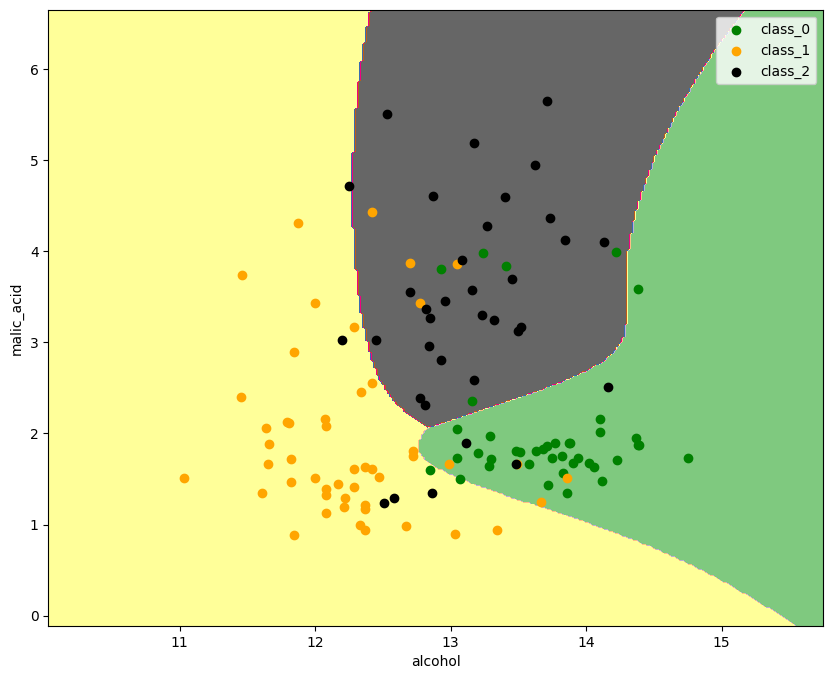

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                        torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(torch.cat([xx.reshape(-1, 1),
                                      yy.reshape(-1, 1)], dim = 1))

preds_class = preds.data.numpy().argmax(axis = 1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap = 'Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0],
                X_train[indexes, 1],
                c = color,
                label = wine.target_names[i],
                cmap = 'Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()